# Challenges for week 6

Now that we've seen how to run statistical testing and create supervised machine learning models in Python, it's time for you to apply this knowledge. This week has three challenges. Make sure to give it a try and complete all of them. 

**Some important notes for the challenges:**
1. These challenges are a warming up, and help you get ready for class. Make sure to give them a try. If you get an error message, try to troubleshoot it (using Google often helps). If all else fails, go to the next challenge (but make sure to hand it in).
2. While we of course like when you get all the answers right, the important thing is to exercise and apply the knowledge. So we will still accept challenges that may not be complete, as long as we see enough effort *for each challenge*. This means that if one of the challenges is not delivered (not started and no attempt shown), we unfortunately will not be able to provide a full grade for that week.
3. Delivering the challenge to the right place is a critical part of the challenge. This means we will only be able to grade and accept challenges that are live on your own private GitHub repository (so with a link starting with https://github.com/uva-cw-digitalanalytics/2021s1-) **and** delivered on time as a Canvas assignment. Watch the videos on Canvas on how to hand in your challenges.

### Facing issues? 

We are constantly monitoring the issues on the GitHub general repository (https://github.com/uva-cw-digitalanalytics/2021s1/issues) to help you out. Don't hesitate to log an issue there, explaining well what the problem is, showing the code you are using, and the error message you may be receiving. 

**Important:** We are only monitoring the repository in weekdays, and until 17.00. Issues logged after this time will most likely be answered the next day. This means you should now wait for our response before submitting a challenge :-)

## Getting setup for the challenges

We will use the Google Store data that we also saw in the video tutorials. Make sure to either have it by cloning the general repository, or downloading it from surfdrive (see link in the General Repository homepage) and placing it in the same folder as you are running this weekly challenge.


## The case
Our website has launched new campaigns to increase in sales (as binary, converted from **order_euros**) and revenue (**order_euros**). We are now only interested in sales (i.e., binary DV).

We are interested in two campaigns:
* The **referral** campaign
* The **CPC** campaign

We want to know if (each campaign led to an increase in sales **compared** to the other campaigns (i.e., any traffic source that is not set as CPC or referral).

### Important note:
Because the dataset is very large and it may take some time to run the code, we will select a random sample of 10% of the visits that are in the dataset. Please run the code below (exactly as it is):

In [105]:
import pandas as pd
import seaborn as sns
%matplotlib inline

In [106]:
from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm
import numpy as np

In [107]:
import lime
from lime import lime_tabular

In [108]:
visitors = pd.read_csv('da6_fulldata.csv.gz')

In [109]:
visitors.head()

,session_id,order_euros,purchase,session_timestamp,user_agent,referral,type_campaign,user_id,reg_name,age,registration_date,initial_referrer,preferential_client
0,5555694754,153.5,1.0,2021-10-06 16:10:27,Mozilla/5.0 (iPhone; CPU iPhone OS 4_2_1 like ...,facebook.com,CPC,NaN,NaN,NaN,NaN,NaN,NaN
1,5555694755,NaN,NaN,2021-09-30 08:36:38,Opera/8.28.(Windows NT 5.1; lo-LA) Presto/2.9....,facebook.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5555694756,NaN,NaN,2021-09-29 15:19:24,Opera/9.44.(Windows NT 6.2; ks-IN) Presto/2.9....,facebook.com,CPC,NaN,NaN,NaN,NaN,NaN,NaN
3,5555694757,NaN,NaN,2021-10-08 02:20:09,Opera/8.34.(Windows NT 10.0; yi-US) Presto/2.9...,facebook.com,influencerA,NaN,NaN,NaN,NaN,NaN,NaN
4,5555694758,NaN,NaN,2021-10-06 19:56:22,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_8...,google.com,organic,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
visitors.columns

Index(['session_id', 'order_euros', 'purchase', 'session_timestamp',
       'user_agent', 'referral', 'type_campaign', 'user_id', 'reg_name', 'age',
       'registration_date', 'initial_referrer', 'preferential_client'],
      dtype='object')

In [111]:
visitors.isna().sum()

session_id                 0
order_euros            37499
purchase               37499
session_timestamp          0
user_agent                 0
referral                   0
type_campaign          23629
user_id                34822
reg_name               34822
age                    34822
registration_date      34822
initial_referrer       34822
preferential_client    47028
dtype: int64

In [112]:
len(visitors)

50000

In [113]:
visitors.dtypes

session_id               int64
order_euros            float64
purchase               float64
session_timestamp       object
user_agent              object
referral                object
type_campaign           object
user_id                float64
reg_name                object
age                    float64
registration_date       object
initial_referrer        object
preferential_client    float64
dtype: object

In [114]:
visitors['purchase'].value_counts()

1.0    12501
Name: purchase, dtype: int64

In [115]:
visitors['referral'].value_counts()

google.com                11127
facebook.com              11109
instagram.com             11045
smith.com                   151
johnson.com                 108
                          ...  
murphy-lopez.com              1
mullins-miller.com            1
kennedy-wright.net            1
moreno-reed.org               1
shields-cunningham.com        1
Name: referral, Length: 8597, dtype: int64

In [116]:
visitors['type_campaign'].value_counts()

influencerA    8405
influencerB    6328
CPC            5252
SEA            3202
organic        3184
Name: type_campaign, dtype: int64

In [117]:
visitors['preferential_client'].value_counts()

1.0    2972
Name: preferential_client, dtype: int64

In [118]:
visitors['order_euros'].describe()

count    12501.000000
mean       177.550356
std         53.545786
min        110.100000
25%        137.600000
50%        162.100000
75%        203.400000
max        439.200000
Name: order_euros, dtype: float64

In [119]:
visitors['order_euros'] = visitors['order_euros'].fillna(0)
visitors['purchase'] = visitors['purchase'].fillna(0)
visitors['preferential_client'] = visitors['preferential_client'].fillna(0)

In [120]:
visitors['type_campaign'] = visitors['type_campaign'].fillna('Other_campaigns')

In [121]:
def recategorize(category):
    if category == 'influencerA':
        return 'influencerA'
    if category == 'influencerB':
        return 'influencerB'
    if category == 'CPC':
        return 'CPC'
   
    else:
        return 'Other_campaigns'

In [122]:
visitors['type_campaign'] = visitors['type_campaign'].apply(recategorize)

In [123]:
def wordlist_any_present(text, query):
    import re
    text = str(text).lower()
    newquery = []
    for word in query:
        newquery.append(str(word).lower())
    tokens = re.findall(r"[\w']+|[.,!?;$@#]", text)
    
    for word in newquery:
        if word in tokens:
            return 1
    return 0

In [124]:
visitors['InfluencerA'] = visitors['type_campaign'].apply(wordlist_any_present, args=(['InfluencerA'],))
visitors['InfluencerB'] = visitors['type_campaign'].apply(wordlist_any_present, args=(['InfluencerB'],))
visitors['CPC'] = visitors['type_campaign'].apply(wordlist_any_present, args=(['CPC'],))
visitors['Other_campaigns'] = visitors['type_campaign'].apply(wordlist_any_present, args=(['other_campaigns'],))

In [125]:
visitors['InfluencerA'].value_counts()

0    41595
1     8405
Name: InfluencerA, dtype: int64

In [126]:
visitors['InfluencerB'].value_counts()

0    43672
1     6328
Name: InfluencerB, dtype: int64

In [127]:
visitors['CPC'].value_counts()

0    44748
1     5252
Name: CPC, dtype: int64

In [128]:
visitors.isna().sum()

session_id                 0
order_euros                0
purchase                   0
session_timestamp          0
user_agent                 0
referral                   0
type_campaign              0
user_id                34822
reg_name               34822
age                    34822
registration_date      34822
initial_referrer       34822
preferential_client        0
InfluencerA                0
InfluencerB                0
CPC                        0
Other_campaigns            0
dtype: int64

In [129]:
visitors['Other_campaigns'].value_counts()

1    30015
0    19985
Name: Other_campaigns, dtype: int64

In [130]:
visitors['purchase'] = visitors['purchase'].astype(int)

In [131]:
visitors['preferential_client'] = visitors['preferential_client'].astype(int)

In [132]:
visitors['referral'].value_counts()

google.com                11127
facebook.com              11109
instagram.com             11045
smith.com                   151
johnson.com                 108
                          ...  
murphy-lopez.com              1
mullins-miller.com            1
kennedy-wright.net            1
moreno-reed.org               1
shields-cunningham.com        1
Name: referral, Length: 8597, dtype: int64

In [133]:
def recategorize(category):
    if category == 'google.com':
        return 'google.com'
    if category == 'facebook.com':
        return 'facebook.com'
    if category == 'instagram.com':
        return 'instagram.com'
   
    else:
        return 'Other_referral'

In [134]:
visitors['referral'] = visitors['referral'].apply(recategorize)

In [135]:
visitors['referral'].value_counts()

Other_referral    16719
google.com        11127
facebook.com      11109
instagram.com     11045
Name: referral, dtype: int64

In [136]:
def wordlist_any_present(text, query):
    import re
    text = str(text).lower()
    newquery = []
    for word in query:
        newquery.append(str(word).lower())
    tokens = re.findall(r"[\w']+|[.,!?;$@#]", text)
    
    for word in newquery:
        if word in tokens:
            return 1
    return 0

In [137]:
visitors['Google'] = visitors['referral'].apply(wordlist_any_present, args=(['google'],))
visitors['Facebook'] = visitors['referral'].apply(wordlist_any_present, args=(['facebook'],))
visitors['Instagram'] = visitors['referral'].apply(wordlist_any_present, args=(['instagram'],))
visitors['Other_referral'] = visitors['referral'].apply(wordlist_any_present, args=(['Other_referral'],))

In [138]:
visitors['Apple_device'] = visitors['user_agent'].apply(wordlist_any_present, args=(['Macintosh', 'iOS','ipad', 'apple', 'iphone'],))

In [139]:
visitors['Apple_device'].value_counts()

0    35363
1    14637
Name: Apple_device, dtype: int64

In [140]:
visitors_ = visitors[['session_id','purchase','order_euros','preferential_client','user_agent','referral','Google','Facebook','Instagram','Other_referral','type_campaign','InfluencerA','InfluencerB','CPC','Other_campaigns','Apple_device']]

In [141]:
visitors_['purchase'].value_counts()

0    37499
1    12501
Name: purchase, dtype: int64

In [142]:
visitors_['purchase'].value_counts(normalize=True)

0    0.74998
1    0.25002
Name: purchase, dtype: float64

In [143]:
visitors_['order_euros'].describe()

count    50000.00000
mean        44.39114
std         81.41259
min          0.00000
25%          0.00000
50%          0.00000
75%        110.10000
max        439.20000
Name: order_euros, dtype: float64

In [144]:
visitors_['type_campaign'].value_counts()

Other_campaigns    30015
influencerA         8405
influencerB         6328
CPC                 5252
Name: type_campaign, dtype: int64

In [145]:
visitors_['type_campaign'].value_counts(normalize=True)

Other_campaigns    0.60030
influencerA        0.16810
influencerB        0.12656
CPC                0.10504
Name: type_campaign, dtype: float64

In [146]:
visitors_[['order_euros','purchase']].describe()

,order_euros,purchase
count,50000.00000,50000.000000
mean,44.39114,0.250020
std,81.41259,0.433029
min,0.00000,0.000000
25%,0.00000,0.000000
50%,0.00000,0.000000
75%,110.10000,1.000000
max,439.20000,1.000000


In [147]:
visitors_.groupby('type_campaign')[['purchase','order_euros']].describe().transpose()

type_campaign              CPC  Other_campaigns  influencerA  influencerB
purchase    count  5252.000000     30015.000000  8405.000000  6328.000000
            mean      0.515232         0.179777     0.282332     0.320164
            std       0.499816         0.384008     0.450161     0.466576
            min       0.000000         0.000000     0.000000     0.000000
            25%       0.000000         0.000000     0.000000     0.000000
            50%       1.000000         0.000000     0.000000     0.000000
            75%       1.000000         0.000000     1.000000     1.000000
            max       1.000000         1.000000     1.000000     1.000000
order_euros count  5252.000000     30015.000000  8405.000000  6328.000000
            mean     95.604303        29.627593    52.829518    60.704630
            std     100.676800        66.508137    89.106578    94.148035
            min       0.000000         0.000000     0.000000     0.000000
            25%       0.000000         0.000000     0.000000     0.000000
            50%     118.400000         0.000000     0.000000     0.000000
            75%     162.200000         0.000000   125.300000   150.200000
            max     439.200000       391.300000   436.400000   434.300000

<AxesSubplot:xlabel='purchase', ylabel='count'>

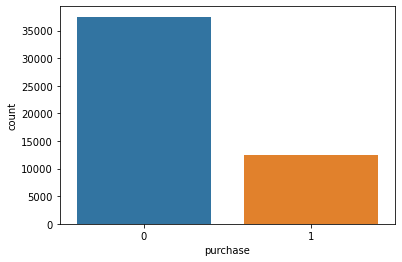

In [148]:
sns.countplot(x='purchase', data=visitors_)

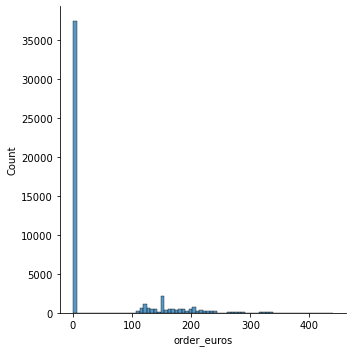

In [149]:
sns.displot(visitors_['order_euros']) 

<AxesSubplot:xlabel='Apple_device', ylabel='count'>

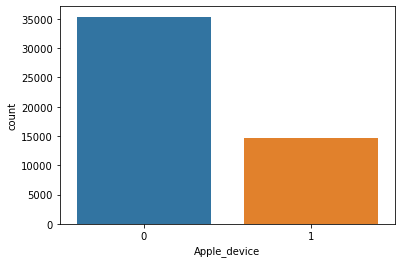

In [150]:
sns.countplot(x='Apple_device', data=visitors_)

<AxesSubplot:xlabel='count', ylabel='type_campaign'>

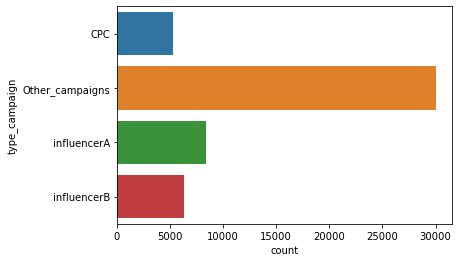

In [151]:
sns.countplot(y='type_campaign', data=visitors_) 

<AxesSubplot:xlabel='count', ylabel='referral'>

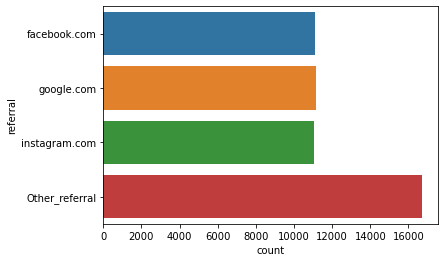

In [152]:
sns.countplot(y='referral', data=visitors_)

<AxesSubplot:xlabel='type_campaign', ylabel='purchase'>

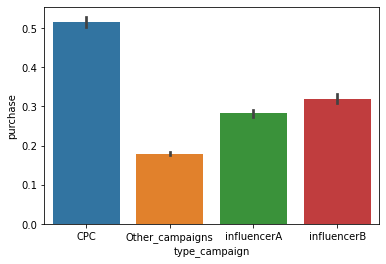

In [153]:
sns.barplot(x='type_campaign', y='purchase', data=visitors_)

<AxesSubplot:xlabel='referral', ylabel='order_euros'>

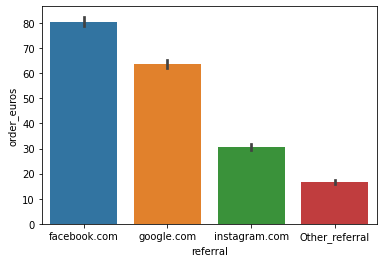

In [154]:
sns.barplot(x='referral', y='order_euros', data=visitors_)

<AxesSubplot:xlabel='Apple_device', ylabel='purchase'>

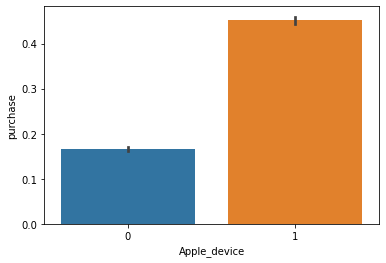

In [155]:
sns.barplot(x='Apple_device', y='purchase', data=visitors_)

<AxesSubplot:xlabel='Apple_device', ylabel='order_euros'>

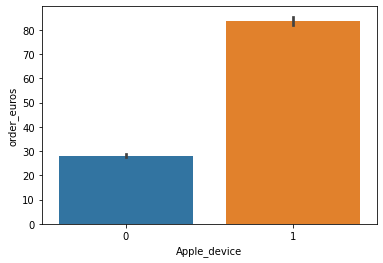

In [156]:
sns.barplot(x='Apple_device', y='order_euros', data=visitors_)

In [157]:
from sklearn.model_selection import train_test_split

In [162]:
visitors_.dtypes

session_id               int64
purchase                 int64
order_euros            float64
preferential_client      int64
user_agent              object
referral                object
Google                   int64
Facebook                 int64
Instagram                int64
Other_referral           int64
type_campaign           object
InfluencerA              int64
InfluencerB              int64
CPC                      int64
Other_campaigns          int64
Apple_device             int64
dtype: object

In [201]:
train, test = train_test_split(visitors_, test_size=0.2, random_state=42)

In [202]:
len(train), len(test)

(40000, 10000)

In [203]:
target = "purchase"
features = ['CPC',  'InfluencerA', 'InfluencerB']

In [204]:
logit_stats = sm.Logit(train[target], sm.add_constant(train[features]))

In [205]:
result_logit = logit_stats.fit()

Optimization terminated successfully.
         Current function value: 0.532993
         Iterations 5


In [206]:
print(result_logit.summary())

                           Logit Regression Results                           
Dep. Variable:               purchase   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39996
Method:                           MLE   Df Model:                            3
Date:                Wed, 25 May 2022   Pseudo R-squ.:                 0.05018
Time:                        13:10:58   Log-Likelihood:                -21320.
converged:                       True   LL-Null:                       -22446.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.5331      0.017    -90.769      0.000      -1.566      -1.500
CPC             1.5973      0.035     45.415      0.000       1.528       1.666
InfluencerA     0.5996      0.032     18.745    

In [207]:
target = "purchase"
features = ['CPC',  'InfluencerA', 'Other_campaigns']

In [208]:
logit_stats1 = sm.Logit(train[target], sm.add_constant(train[features]))

In [209]:
result_logit1 = logit_stats1.fit()

Optimization terminated successfully.
         Current function value: 0.532993
         Iterations 5


In [210]:
print(result_logit.summary())

                           Logit Regression Results                           
Dep. Variable:               purchase   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39996
Method:                           MLE   Df Model:                            3
Date:                Wed, 25 May 2022   Pseudo R-squ.:                 0.05018
Time:                        13:10:59   Log-Likelihood:                -21320.
converged:                       True   LL-Null:                       -22446.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.5331      0.017    -90.769      0.000      -1.566      -1.500
CPC             1.5973      0.035     45.415      0.000       1.528       1.666
InfluencerA     0.5996      0.032     18.745    

In [211]:
features_controls = ['CPC', 'InfluencerA', 'InfluencerB', 'Apple_device','Google']

In [212]:
logit_stats_user = sm.Logit(train[target], sm.add_constant(train[features_controls]))

In [213]:
result_logit_user = logit_stats_user.fit()

Optimization terminated successfully.
         Current function value: 0.468279
         Iterations 6


In [214]:
print(result_logit_user.summary())

                           Logit Regression Results                           
Dep. Variable:               purchase   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39994
Method:                           MLE   Df Model:                            5
Date:                Wed, 25 May 2022   Pseudo R-squ.:                  0.1655
Time:                        13:11:01   Log-Likelihood:                -18731.
converged:                       True   LL-Null:                       -22446.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.6793      0.028    -95.189      0.000      -2.734      -2.624
CPC              1.9411      0.040     49.075      0.000       1.864       2.019
InfluencerA      1.1597      0.038     30.76

In [215]:
features_controls = ['CPC', 'InfluencerA', 'Other_campaigns', 'Apple_device','Google']

In [216]:
logit_stats_user1 = sm.Logit(train[target], sm.add_constant(train[features_controls]))

In [217]:
result_logit_use1r = logit_stats_user1.fit()

Optimization terminated successfully.
         Current function value: 0.468279
         Iterations 6


In [218]:
print(result_logit_user.summary())

                           Logit Regression Results                           
Dep. Variable:               purchase   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39994
Method:                           MLE   Df Model:                            5
Date:                Wed, 25 May 2022   Pseudo R-squ.:                  0.1655
Time:                        13:11:02   Log-Likelihood:                -18731.
converged:                       True   LL-Null:                       -22446.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.6793      0.028    -95.189      0.000      -2.734      -2.624
CPC              1.9411      0.040     49.075      0.000       1.864       2.019
InfluencerA      1.1597      0.038     30.76

In [232]:
logit_clf = LogisticRegression(max_iter=1000, fit_intercept = True)

In [233]:
features = ['CPC',  'InfluencerA', 'InfluencerB']

In [234]:
logit_clf.fit(train[features], train[target])

LogisticRegression(max_iter=1000)

In [235]:
logit_clf.predict_proba([[1,0,0]])

array([[0.48433188, 0.51566812]])

In [236]:
logit_clf.predict_proba([[0,1,0]])

array([[0.71787546, 0.28212454]])

In [237]:
logit_clf.predict_proba([[0,0,1]])

array([[0.67918345, 0.32081655]])

In [226]:
logit_clf_user = LogisticRegression(max_iter=1000, fit_intercept = True)

In [227]:
logit_clf_user.fit(train[features_controls], train[target])

LogisticRegression(max_iter=1000)

In [228]:
logit_clf_user.predict_proba([[1,0,0,0,0]])

array([[0.67676031, 0.32323969]])

In [229]:
logit_clf_user.predict_proba([[1,0,0,1,1]])

array([[0.10390315, 0.89609685]])

In [230]:
logit_clf_user.predict_proba([[1,0,0,1,0]])

array([[0.29610307, 0.70389693]])

In [231]:
logit_clf_user.predict_proba([[1,0,0,0,1]])

array([[0.36592428, 0.63407572]])

In [238]:
test['predicted_bounce_logit'] = logit_clf.predict(test[features])

<ipython-input-238-9fbbfa671ffe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_bounce_logit'] = logit_clf.predict(test[features])


In [239]:
test['predicted_bounce_logit'].value_counts()

0    8955
1    1045
Name: predicted_bounce_logit, dtype: int64

In [240]:
test[['purchase', 'predicted_bounce_logit']].head()

,purchase,predicted_bounce_logit
33553,0,0
9427,1,0
199,0,0
12447,0,0
39489,1,0


In [241]:
test['predicted_bounce_logit_user'] = logit_clf_user.predict(test[features_controls])

<ipython-input-241-410e8bc40bfd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_bounce_logit_user'] = logit_clf_user.predict(test[features_controls])


In [242]:
test['predicted_bounce_logit_user'].value_counts()

0    8001
1    1999
Name: predicted_bounce_logit_user, dtype: int64

In [243]:
test[['purchase', 'predicted_bounce_logit', 'predicted_bounce_logit_user']].head()

,purchase,predicted_bounce_logit,predicted_bounce_logit_user
33553,0,0,0
9427,1,0,1
199,0,0,0
12447,0,0,0
39489,1,0,0


In [245]:
from sklearn.metrics import confusion_matrix

In [247]:
print(confusion_matrix(test['purchase'], test['predicted_bounce_logit']))

[[6946  510]
 [2009  535]]


In [248]:
print(confusion_matrix(test['purchase'], test['predicted_bounce_logit_user']))

[[6669  787]
 [1332 1212]]


In [249]:
from sklearn.metrics import classification_report

In [250]:
print(classification_report(test['purchase'], test['predicted_bounce_logit']))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      7456
           1       0.51      0.21      0.30      2544

    accuracy                           0.75     10000
   macro avg       0.64      0.57      0.57     10000
weighted avg       0.71      0.75      0.71     10000



In [251]:
print(classification_report(test['purchase'], test['predicted_bounce_logit_user']))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      7456
           1       0.61      0.48      0.53      2544

    accuracy                           0.79     10000
   macro avg       0.72      0.69      0.70     10000
weighted avg       0.78      0.79      0.78     10000



In [252]:
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree._export import plot_tree

In [253]:
dt_clf = DecisionTreeClassifier()

In [254]:
dt_clf.fit(train[features], train[target])

DecisionTreeClassifier()

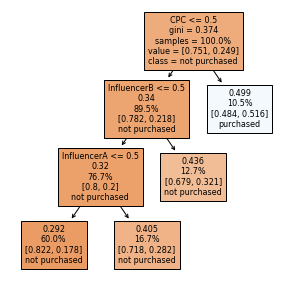

In [255]:
plt.figure(figsize=(5,5))
plot_tree(dt_clf, proportion=True, label='root', 
          feature_names=['CPC',  'InfluencerA', 'InfluencerB'], class_names=['not purchased','purchased'], filled=True, fontsize=8)
plt.show()

In [256]:
test['predicted_purchase'] = dt_clf.predict(test[features])

<ipython-input-256-0c3d6b09c017>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_purchase'] = dt_clf.predict(test[features])


In [257]:
dt_clf_user = DecisionTreeClassifier()

In [258]:
dt_clf_user.fit(train[features_controls], train[target])

DecisionTreeClassifier()

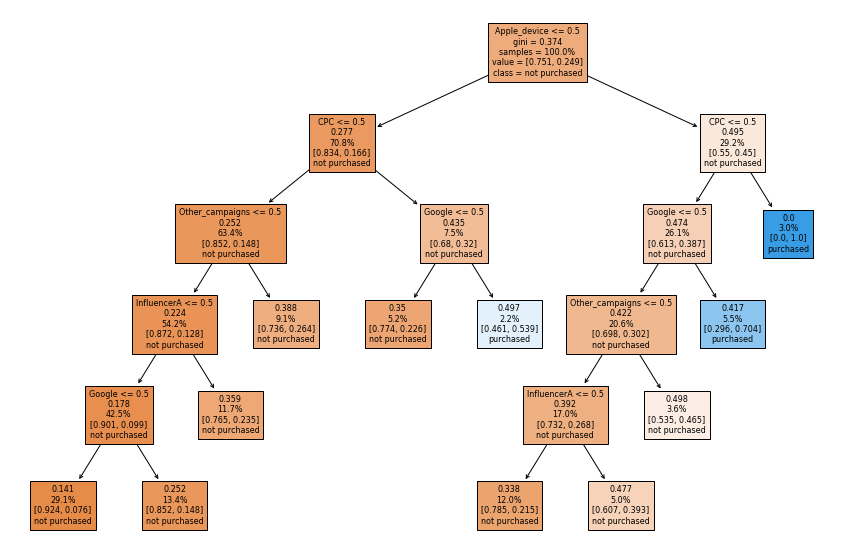

In [259]:
plt.figure(figsize=(15,10))
plot_tree(dt_clf_user, proportion=True, 
          label='root', 
          feature_names=['CPC', 'InfluencerA', 'Other_campaigns', 'Apple_device','Google'], 
          class_names=['not purchased','purchased'], 
          filled=True, fontsize=8)
plt.show()

In [260]:
test['predicted_purchase_user'] = dt_clf_user.predict(test[features_controls])

<ipython-input-260-a344e5452caa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_purchase_user'] = dt_clf_user.predict(test[features_controls])


In [261]:
print(classification_report(test['purchase'], test['predicted_purchase']))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      7456
           1       0.51      0.21      0.30      2544

    accuracy                           0.75     10000
   macro avg       0.64      0.57      0.57     10000
weighted avg       0.71      0.75      0.71     10000



In [262]:
print(classification_report(test['purchase'], test['predicted_purchase_user']))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88      7456
           1       0.74      0.32      0.45      2544

    accuracy                           0.80     10000
   macro avg       0.78      0.64      0.66     10000
weighted avg       0.79      0.80      0.77     10000



## Challenge 1

Create two models for statistical testing (with statsmodels). One only with the campaign information (cpc and referral), and a second model with at least one additional independent or control variable. It can be one of the variables we showed in the DA6 tutorial, or another. Sales, as a binary variable (converted from order_euros) should be your DV.

You need to:
1. Justify your choice (in MarkDown) for the additional variable for the second model
2. Create both models using statsmodels
3. Interpret the models (i.e., what do they tell about the influence of the IV's in the DV)
4. Indicate which model you'd choose, and why

**IMPORTANT:** Don't forget to split your data in train / test datasets, and use only the train dataset here, as done also in the DA6 tutorial.

## Challenge 2

Using the LogisticRegression classifier from **sklearn**, recreate the same models that you created in statsmodels for challenge 1 using your training dataset. Then compare both models in terms of:
1. How their confusion matrix looks like for the test dataset
2. Their precision, recall and F1-score for the test dataset
3. Indicate which model you'd choose, and why

## Challenge 3

Using the DecisionTree classifier from **sklearn**, recreate the best performing model from challenge 2 (the one you indicated you'd choose). After the DecisionTree model is created, please:
1. Create a chart for the decision tree
2. Interpret the precision, recall and F1-score of this model for the test dataset (compared to the best model from challenge 2)
3. Indicate which model you'd choose, and why